In [56]:
import numpy as np 
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
from head import AmplitudePhaseDistance
from geomstats.geometry.functions import SRVF
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from matplotlib import cm
import matplotlib
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from matplotlib.colors import Normalize
import pickle
plt.rcParams.update({
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 15,
                     "savefig.dpi": 400,
                     "savefig.bbox": 'tight',
                     'text.latex.preamble': r'\usepackage{amsfonts}'
                    }
                   )

In [2]:
def load_spectra(path):
    for itr in range(7):
        spectra_iteration = pd.read_excel(path + str(itr) + '.xlsx').values
        wavelength = spectra_iteration[:,0]
        if itr == 0:
            spectra_all = spectra_iteration[:,1:]
        else:
            spectra_all = np.hstack((spectra_all, spectra_iteration[:,1:]))
    return spectra_all, wavelength 

def load_x(path):
    all_x = np.load(path + str(7) + '/train_x.npy') #All x_values from 0th iteration to iteration-1 
    return all_x

In [3]:
AP_ROD_y, wavelength = load_spectra('../data_AP_ROD/')
AP_SPHERE_y, _ = load_spectra('../data_AP_SPHERE/')
SRVF_ROD_y, _ = load_spectra('../data_SRVF_ROD/')
SRVF_SPHERE_y, _ = load_spectra('../data_SRVF_SPHERE/')
euclidean_ROD_y, _ = load_spectra('../data_euclidean_ROD/')
euclidean_SPHERE_y, _ = load_spectra('../data_euclidean_SPHERE/')
peakwv_ROD_y, _ = load_spectra('../data_peakwv_ROD/')
peakwv_SPHERE_y, _ = load_spectra('../data_peakwv_SPHERE/')

In [4]:
AP_ROD_x = load_x('../data_AP_ROD/')
AP_SPHERE_x = load_x('../data_AP_SPHERE/')
SRVF_ROD_x = load_x('../data_SRVF_ROD/')
SRVF_SPHERE_x = load_x('../data_SRVF_SPHERE/')
euclidean_ROD_x = load_x('../data_euclidean_ROD/')
euclidean_SPHERE_x = load_x('../data_euclidean_SPHERE/')
peakwv_ROD_x = load_x('../data_peakwv_ROD/')
peakwv_SPHERE_x = load_x('../data_peakwv_SPHERE/')

In [5]:
target = pd.read_excel('Target_Rod.xlsx')
target = np.asarray(target)
xt = target[:,0]
rod_target = target[:,1]
target = pd.read_excel('Target_Sphere.xlsx')
target = np.asarray(target)
xt = target[:,0]
sphere_target = target[:,1]

In [6]:
#spectra
SPHERES_y = np.hstack((peakwv_SPHERE_y, euclidean_SPHERE_y, SRVF_SPHERE_y, AP_SPHERE_y))
RODS_y = np.hstack((peakwv_ROD_y, euclidean_ROD_y, SRVF_ROD_y, AP_ROD_y))

In [7]:
#concentrations
SPHERES_x = np.vstack((peakwv_SPHERE_x, euclidean_SPHERE_x, SRVF_SPHERE_x, AP_SPHERE_x))
RODS_x = np.vstack((peakwv_ROD_x, euclidean_ROD_x, SRVF_ROD_x, AP_ROD_x))

In [8]:
def Euclidean(f1,f2):
    d = distance.euclidean(f1,f2)    
    return -d

def peakwv_sphere(f1,f2):
    d = (np.abs((np.argmax(f1) - np.argmax(f2))/100) + np.abs(np.max(f1) - np.max(f2)))
    return -d

def AP(f1,f2):
    da, dp = AmplitudePhaseDistance(f1,f2,xt)
    return -(da + dp)

def SRVF_metric(f1,f2):
    target = pd.read_excel('Target_Rod.xlsx')
    target = np.asarray(target)
    xt = target[:,0]
    M = SRVF(xt.reshape(-1,1).flatten())
    yi = np.asarray(f1).reshape(-1,1).flatten()
    yt = np.asarray(f2).reshape(-1,1).flatten()
    score = -M.metric.dist(yt,yi)
    return score
    

In [15]:
def calculate_distance(metric, concentrations, spectra, target):
    dist = []
    spectra = spectra.T
    for i in range(spectra.shape[0]):
        d = metric(target, spectra[i,:])
        dist.append(d)
    dist = np.array(dist).reshape(-1,1)
    array = np.hstack((dist, concentrations, spectra))
    sorted_array = array[np.argsort(array[:, 0])]
    return sorted_array 

In [93]:
fx = AP_ROD_x
fy = AP_ROD_y
array = calculate_distance(AP, fx, fy, rod_target)

In [94]:
print('Best Score: ', array[-1,0])
print('Best Volumes: ', array[-1,1:3]*140+10)

Best Score:  -0.059771307884644034
Best Volumes:  [110.48861004 105.831123  ]


In [96]:
array[:,0]

array([-0.87569867, -0.8698789 , -0.78982325, -0.55821373, -0.4237132 ,
       -0.35318897, -0.33554826, -0.2326587 , -0.12401943, -0.11810053,
       -0.09952989, -0.09744266, -0.09477129, -0.09087372, -0.08987086,
       -0.08874472, -0.08860827, -0.08741685, -0.08493583, -0.06871634,
       -0.06823045, -0.06642885, -0.06550979, -0.06545421, -0.06351368,
       -0.06304913, -0.05979964, -0.05977131])

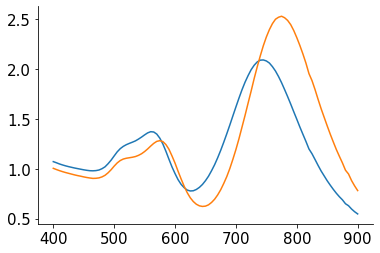

In [101]:
plt.plot(xt, array[-1,3:], label = 'Best Sample')
plt.plot(xt, rod_target, label = 'Target')

In [102]:
#all_exp = {}

In [103]:
metric_name = 'AP_ROD'
all_exp[metric_name + '_best_score'] = array[-1,0]
all_exp[metric_name + '_best_volumes'] = array[-1,1:3]*140+10
all_exp[metric_name + '_best_spectra'] = array[-1,3:]

In [104]:
all_exp

{'peak_wv_SPHERE_best_score': -0.8328895484996794,
 'peak_wv_SPHERE_best_spectra': array([1.014, 1.003, 0.993, 0.984, 0.976, 0.969, 0.963, 0.958, 0.954,
        0.953, 0.953, 0.955, 0.959, 0.968, 0.98 , 0.997, 1.024, 1.057,
        1.105, 1.161, 1.231, 1.308, 1.384, 1.449, 1.498, 1.524, 1.524,
        1.502, 1.459, 1.405, 1.341, 1.27 , 1.194, 1.122, 1.049, 0.98 ,
        0.916, 0.855, 0.8  , 0.75 , 0.708, 0.669, 0.634, 0.604, 0.577,
        0.554, 0.534, 0.516, 0.5  , 0.486, 0.474, 0.463, 0.453, 0.444,
        0.435, 0.428, 0.421, 0.415, 0.409, 0.404, 0.399, 0.395, 0.392,
        0.389, 0.387, 0.384, 0.383, 0.383, 0.381, 0.378, 0.375, 0.372,
        0.369, 0.366, 0.363, 0.36 , 0.356, 0.353, 0.35 , 0.347, 0.344,
        0.342, 0.339, 0.337, 0.337, 0.336, 0.338, 0.34 , 0.339, 0.338,
        0.338, 0.334, 0.333, 0.333, 0.335, 0.337, 0.337, 0.332, 0.333,
        0.333, 0.333]),
 'peak_wv_SPHERE_best_volumes': array([ 10.14000001, 124.38963819]),
 'euclidean_SPHERE_best_score': -0.216647178

In [105]:
with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(all_exp, f)

In [106]:
with open('saved_dictionary.pkl', 'rb') as func:
    loaded_dict = pickle.load(func)

In [107]:
loaded_dict

{'peak_wv_SPHERE_best_score': -0.8328895484996794,
 'peak_wv_SPHERE_best_spectra': array([1.014, 1.003, 0.993, 0.984, 0.976, 0.969, 0.963, 0.958, 0.954,
        0.953, 0.953, 0.955, 0.959, 0.968, 0.98 , 0.997, 1.024, 1.057,
        1.105, 1.161, 1.231, 1.308, 1.384, 1.449, 1.498, 1.524, 1.524,
        1.502, 1.459, 1.405, 1.341, 1.27 , 1.194, 1.122, 1.049, 0.98 ,
        0.916, 0.855, 0.8  , 0.75 , 0.708, 0.669, 0.634, 0.604, 0.577,
        0.554, 0.534, 0.516, 0.5  , 0.486, 0.474, 0.463, 0.453, 0.444,
        0.435, 0.428, 0.421, 0.415, 0.409, 0.404, 0.399, 0.395, 0.392,
        0.389, 0.387, 0.384, 0.383, 0.383, 0.381, 0.378, 0.375, 0.372,
        0.369, 0.366, 0.363, 0.36 , 0.356, 0.353, 0.35 , 0.347, 0.344,
        0.342, 0.339, 0.337, 0.337, 0.336, 0.338, 0.34 , 0.339, 0.338,
        0.338, 0.334, 0.333, 0.333, 0.335, 0.337, 0.337, 0.332, 0.333,
        0.333, 0.333]),
 'peak_wv_SPHERE_best_volumes': array([ 10.14000001, 124.38963819]),
 'euclidean_SPHERE_best_score': -0.216647178